In [67]:
# hide
from pathlib import Path
import pandas as pd
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import altair as alt


In [104]:
# hide
DATA_DIR = Path('data')
def load(filename):
    f = open(DATA_DIR/filename,"rb")
    return pickle.load(f)
    
def save(data, filename):
    with open(DATA_DIR/filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

from parameters import party_colors, parties, party_size
party_size = {k: v*100 for k,v in party_size.items()}

In [69]:
df = load('df_including_topics_full.pickle')
df['Voor'].unique()

array([117.,  83.,  45., 112.,  38.,  68.,  34., 140., 150.,  37.,  70.,
         9.,  30.,   1.,  39., 101.,  65., 138.,  10.,  76.,  36.,  79.,
        12.,  33.,  49.,  42.,  41.,  27.,  67.,  35.,  31.,  43.,  46.,
        44., 128., 141.,  69., 149., 125.,  21.,  25., 113., 123., 108.,
        73.,  94., 119.,  74.,  97., 124.,   5., 143., 104.,  57., 100.,
       110., 109., 106.,  32., 137., 103., 147., 129., 148.,  59.,  77.,
        80., 126.,  82., 107.,  98.,  90.,  56.,   0., 132., 139.,  61.,
        47.,  40.,  52.,  20., 118.,  17., 120.,  91.,  24., 116.,  58.,
       130.,  95.,  29.,  55.,  16.,  88.,  86.,   2.,  63.,  84.,  78.,
        64.,  81., 144., 135.,  93.,  28.,  50.,  60., 145., 142.,  96.,
        72.,  48.,  85., 134., 114.,  66.,  89.,  22.,  71.,  19.,  99.,
        87.,  11.,  54.,  13.,  53.,  51., 122., 127., 105., 115.,  92.,
        26., 102.,  14., 111.,  23.,  62.,  15., 121.,   7., 133., 131.,
       146.,   8.,   6.,  18.,   4.,  75., 136.,   

In [70]:
# hide
df = load('df_including_topics_full.pickle')
print(len(df))
df = df[df['Kamer']=='Rutte IV']
print('after looking at Rutte IV', len(df))
df = df[df['Voor']<150]
print('after removing unanimous motions',len(df))

39244
after looking at Rutte IV 9007
after removing unanimous motions 8321


In [71]:
def get_same_vote_percentage(party1, party2):
    return round(sum(df['Stem_'+party1]==df['Stem_'+party2]) / len(df)*100)

In [84]:
source = pd.DataFrame([(p1,p2,get_same_vote_percentage(p1,p2)) for p1 in parties for p2 in parties])
base = alt.Chart(source)
chart = base.mark_rect().encode(
    alt.X('0:N',sort=parties,axis=alt.Axis(title=None)),
    alt.Y('1:N', sort=parties,axis=alt.Axis(title=None) ),
    color=alt.Color("2:Q", 
                      scale = alt.Scale(scheme="greens"), legend=alt.Legend(title='overeenkomst%', orient='top')),
)
text = base.mark_text(baseline='middle', color='black').encode(
    alt.X('0:N', sort=parties),
    alt.Y('1:N', sort=parties),
    alt.Text('2:N'))

chart + text

alt.LayerChart(...)

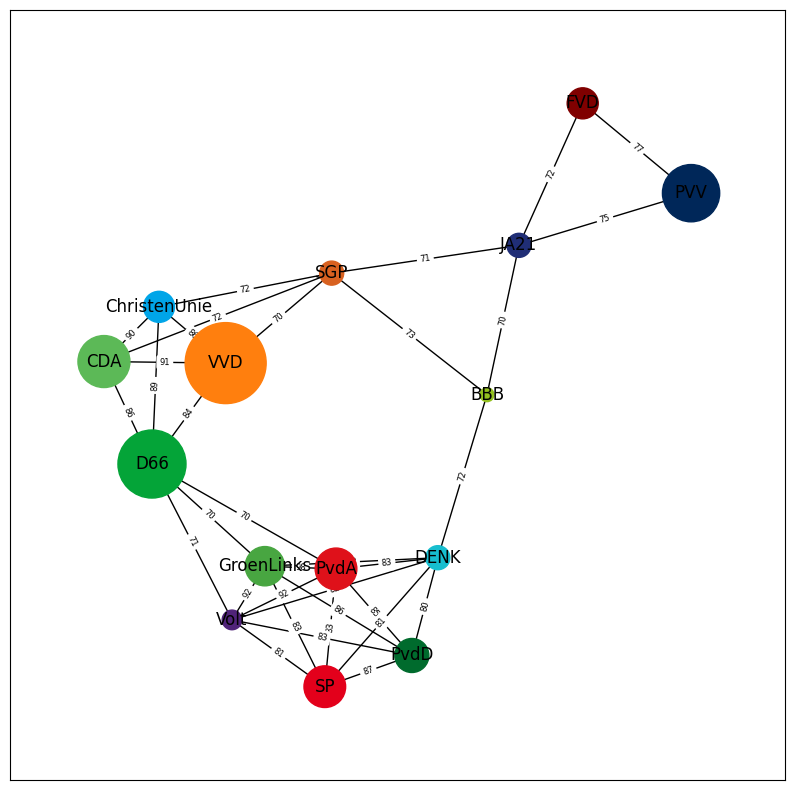

In [92]:
G = nx.Graph()
for p1 in parties:
    for p2 in parties:
        if p1 != p2:
            same_vote = get_same_vote_percentage(p1,p2)
            if same_vote >= 70:
                G.add_edge(p1,p2,weight=same_vote, len=1/(same_vote-0) )
G.add_nodes_from(parties)
# G.remove_nodes_from(['FVD', 'PVV','50PLUS' ])
color_map = [party_colors[node] for node in G]

pos = nx.nx_agraph.graphviz_layout(G,prog='neato', args ='')

plt.figure(figsize=(10,10))
nx.draw_networkx(G, pos,font_size=12, node_color=color_map, node_size=[party_size[n] for n in G.nodes()])
labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,label_pos=0.5, font_size=6)
plt.margins(0.1,0.1)
plt.gcf()
plt.savefig('links_relaties.png')
# plt.draw()

In [74]:
overall_topic_counts = df['Topic'].value_counts()
def get_disagreement_topics(party1, party2):
    print('\n',party1,party2)
    print((df[df['Stem_'+party1]!=df['Stem_'+party2]]['Topic'].value_counts() / overall_topic_counts).sort_values()[-5:])
for p1 in parties:
    for p2 in parties:
        if p1 != p2 and p1<p2:
            get_disagreement_topics(p1,p2)


 CDA ChristenUnie
Topic
Vervoer                     0.112903
Milieu & Klimaat            0.132773
Landbouw & Dierenwelzijn    0.153693
Justitie                    0.154639
Immigratie                  0.159041
Name: count, dtype: float64

 CDA D66
Topic
Rechtsstaat                 0.191038
Milieu & Klimaat            0.200000
Immigratie                  0.209150
Justitie                    0.234536
Landbouw & Dierenwelzijn    0.239521
Name: count, dtype: float64

 CDA GroenLinks
Topic
Vervoer                     0.419355
Zorg                        0.422777
Werk & Pensioen             0.476190
Milieu & Klimaat            0.480672
Landbouw & Dierenwelzijn    0.510978
Name: count, dtype: float64

 CDA PVV
Topic
Algemene zaken     0.555031
Energie            0.558140
Financien          0.559611
Werk & Pensioen    0.621032
Overig             0.794712
Name: count, dtype: float64

 CDA PvdA
Topic
Energie                     0.409302
Zorg                        0.418097
Milieu & Klimaat      

# Medeindieners graph

In [75]:
chambers = list(df['Kamer'].unique())
medeindiener_perc = pd.DataFrame({})
for chamber in chambers:
    moties_in_year = df.loc[(df['Kamer'] == chamber)]
    moties_in_year = moties_in_year.dropna(axis=1, how='all')
    indieners = [c for c in moties_in_year.columns if 'Indiener' in c and c != 'Indiener_persoon']
    medeindieners = [c for c in moties_in_year.columns if 'Medeindiener' in c and c != 'Medeindiener_persoon']
    stem = ['Stem_'+c[13:] for c in medeindieners]
    assert len(stem) == len(medeindieners)
    for p in indieners:
        partij_moties =  moties_in_year.loc[(moties_in_year[p]==1)]
        if min(partij_moties[stem].notna().sum().values) == 0:
            continue
        res = (partij_moties[medeindieners].sum() / partij_moties[stem].notna().sum().values)
        res = pd.DataFrame({'support':res.index.str[13:],'percentage':res.values, 'mede':partij_moties[medeindieners].sum(), 'stem':partij_moties[stem].notna().sum().values})
        res['partij'] = p[9:]
        res['kamer']= chamber
        # how often did the party cosign & vote / how often did the party vote
        res2 =partij_moties[medeindieners].values * partij_moties[stem].values
        res2 = pd.DataFrame({'support': [s[5:] for s in stem], 'percentage':np.nansum(res2, axis=0)/partij_moties[stem].notna().sum().values})
        res2['partij']= p[9:]
        res2['kamer']= chamber
        medeindiener_perc = pd.concat([medeindiener_perc, res2], ignore_index=True)    


In [76]:
medeindiener_perc

,support,percentage,partij,kamer
0,50PLUS,0.0,BBB,Rutte IV
1,BBB,0.0,BBB,Rutte IV
2,BIJ1,0.008621,BBB,Rutte IV
3,CDA,0.026764,BBB,Rutte IV
4,ChristenUnie,0.017032,BBB,Rutte IV
...,...,...,...,...
331,PvdD,0.087209,Volt,Rutte IV
332,SGP,0.040698,Volt,Rutte IV
333,SP,0.034884,Volt,Rutte IV
334,VVD,0.034884,Volt,Rutte IV


In [77]:
# hide_input
import altair as alt
medeindiener_perc = medeindiener_perc[medeindiener_perc['support'].isin(parties)]
medeindiener_perc = medeindiener_perc[medeindiener_perc['partij'].isin(parties)]

chart = alt.Chart(medeindiener_perc).mark_rect().encode(
    x=alt.X('partij:N', sort=list(parties)),
    y=alt.Y('support:N', sort=list(parties)),    
    color=alt.Color('percentage', scale=alt.Scale(scheme='greens'),
    legend=alt.Legend(orient="right",format='%'))
).transform_filter(alt.FieldOneOfPredicate(field='kamer', oneOf=['Rutte IV'])).properties(height=200,width=200)

chart.encoding.y.title = 'mede-ingediend door'
chart.encoding.x.title = 'motie ingediend door'
chart

alt.Chart(...)

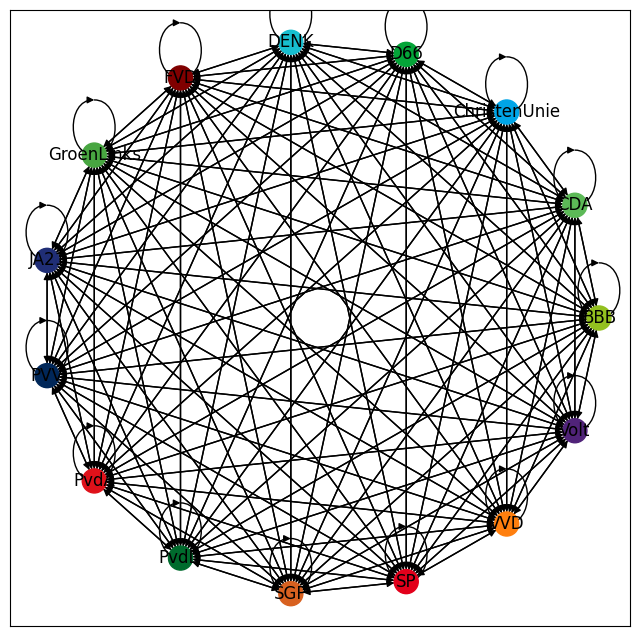

In [78]:
# just a nice picture
G = nx.DiGraph()
for _,info in medeindiener_perc.iterrows():
    p1, weight, p2, _ = info
    G.add_edge(p1,p2,weight=round(weight*100))
color_map = [party_colors[node] for node in G]

pos=nx.circular_layout(G, scale=0.9, center = (0,0)) # pos = nx.nx_agraph.graphviz_layout(G)
plt.figure(figsize=(8,8))
plt.xlim([-1, 1])
plt.ylim([-1, 1])
nx.draw_networkx(G, pos, node_color=color_map)

In [103]:
medeindiener_perc.sort_values(by='percentage',ascending=False)[:20]

,support,percentage,partij,kamer
219,GroenLinks,0.638146,PvdA,Rutte IV
162,PvdA,0.580286,GroenLinks,Rutte IV
297,CDA,0.434049,VVD,Rutte IV
66,CDA,0.42711,ChristenUnie,Rutte IV
46,ChristenUnie,0.35214,CDA,Rutte IV
61,VVD,0.346304,CDA,Rutte IV
324,GroenLinks,0.325581,Volt,Rutte IV
330,PvdA,0.284884,Volt,Rutte IV
299,D66,0.280675,VVD,Rutte IV
68,D66,0.2711,ChristenUnie,Rutte IV


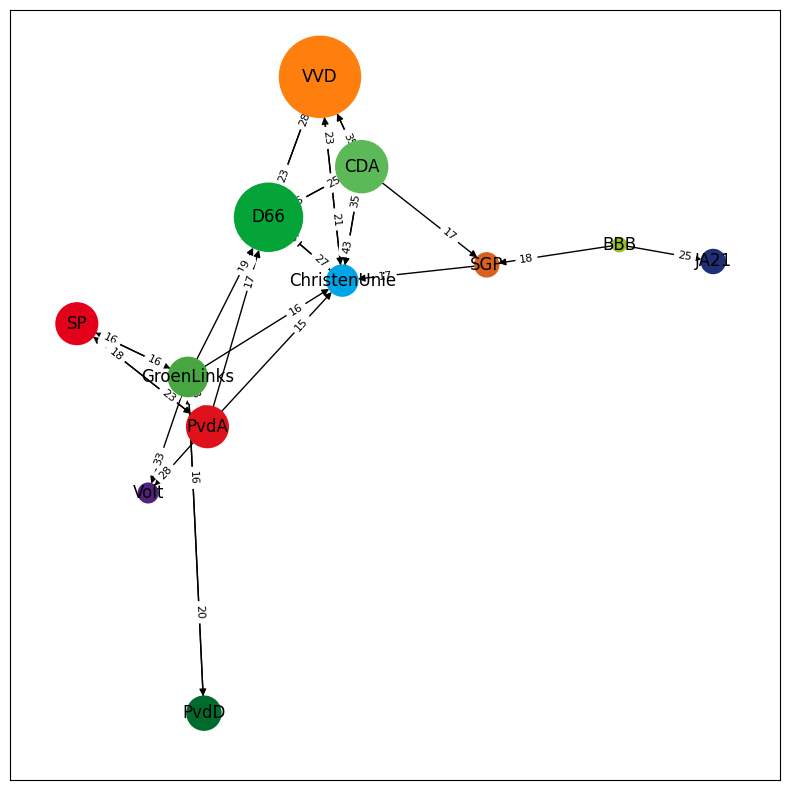

In [102]:
G = nx.DiGraph()
for p in parties:
    G.add_node(p,height=.30,width=.1)
for _,info in medeindiener_perc.iterrows():
    p1, weight, p2, _ = info
    G.add_node(p1)
    if weight > 0.15 and p1 != p2:    
        G.add_edge(p1,p2, weight=round(weight*100),  len=1/round(weight*100))
G.remove_nodes_from(['FVD', 'PVV', 'DENK', '50PLUS'])
color_map = [party_colors[node] for node in G]

for graphviz_type in ['neato']:
    pos = nx.nx_agraph.graphviz_layout(G,prog=graphviz_type, args ='')
    plt.figure(figsize=(8,8))
    nx.draw_networkx(G, pos, node_color=color_map, node_size=[party_size[n] for n in G.nodes()])
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=8,label_pos=0.3)
    plt.tight_layout()
    plt.gcf()
    plt.savefig('network.png')

# Support resultions of other parties

In [98]:
stem_perc = pd.DataFrame({})
for chamber in chambers:
    moties_in_year = df.loc[(df['Kamer'] == chamber)]
    moties_in_year = moties_in_year.dropna(axis=1, how='all')
    indieners = [c for c in moties_in_year.columns if 'Indiener' in c]
    stem = [c for c in moties_in_year.columns if 'Stem' in c][1:]
    
    for p in indieners:
        partij_moties =  moties_in_year.loc[(moties_in_year[p]==1)] 
        
        partij_moties = partij_moties.replace(-1,0)
        res = (partij_moties[stem].sum()/partij_moties[stem].notna().sum())
        res = pd.DataFrame({'support':res.index.str[5:],'percentage':res.values})
        res['partij']= p[9:]
        res['kamer'] = chamber
        stem_perc = pd.concat([stem_perc, res], ignore_index=True)    
stem_perc = stem_perc[stem_perc['support'].isin(parties)]
stem_perc = stem_perc[stem_perc['partij'].isin(parties)]
stem_perc.sort_values(by='percentage', ascending=False, inplace = True)
stem_perc = stem_perc[stem_perc['support'] != stem_perc['partij']]
stem_perc[:15]

,support,percentage,partij,kamer
345,GroenLinks,0.996435,PvdA,Rutte IV
230,Volt,0.993641,GroenLinks,Rutte IV
356,Volt,0.989305,PvdA,Rutte IV
225,PvdA,0.988871,GroenLinks,Rutte IV
379,BBB,0.980237,SGP,Rutte IV
146,Volt,0.979622,D66,Rutte IV
226,PvdD,0.969793,GroenLinks,Rutte IV
415,PvdD,0.967213,SP,Rutte IV
456,PvdA,0.965116,Volt,Rutte IV
450,GroenLinks,0.965116,Volt,Rutte IV


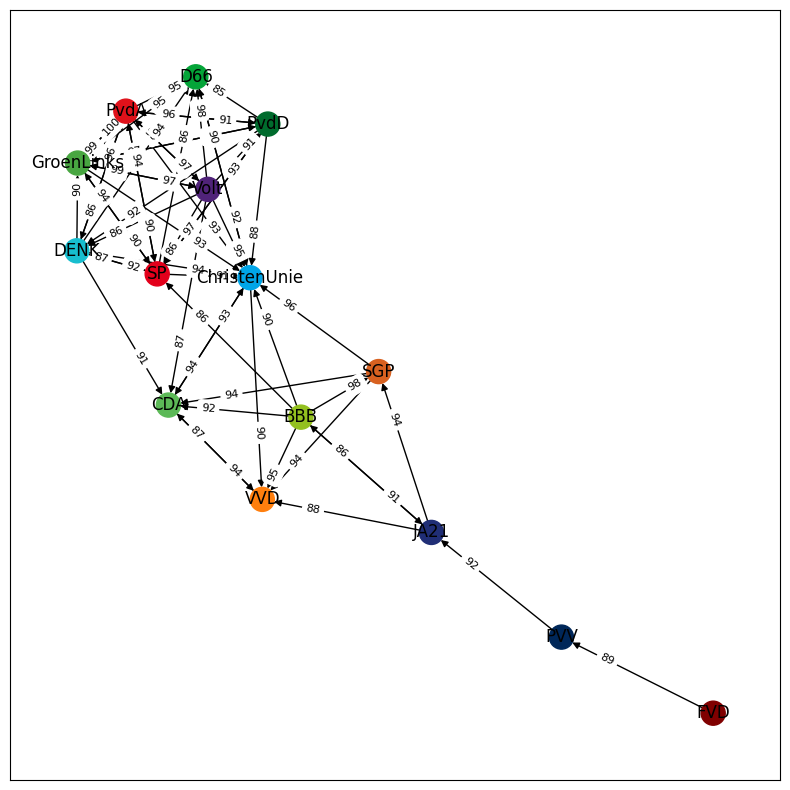

In [101]:
# hide_input

G = nx.DiGraph()
for _,info in stem_perc.iterrows():
    p1, weight, p2, _ = info
    G.add_node(p1)
    if weight > 0.85 and p1 != p2:    
        G.add_edge(p1,p2, weight=round(weight*100),  len=1/round(weight*100))
    # G.add_edge("SGP","VVD", weight=1,  len=1)
# G.remove_nodes_from(['FVD', 'PVV', 'DENK'])
color_map = [party_colors[node] for node in G]

for graphviz_type in ['neato']:
    pos = nx.nx_agraph.graphviz_layout(G,prog=graphviz_type, args ='')
    plt.figure(figsize=(8,8))
    nx.draw_networkx(G, pos, node_color=color_map)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels,font_size=8,label_pos=0.3)
    plt.tight_layout()
    plt.show()
    # plt.gcf()
    # plt.savefig('network.png')